In [19]:
!pip install tweet-preprocessor
!pip install google_trans_new
!pip install tweepy
!pip install textblob
!pip install wordcloud
!pip install nltk

In [20]:
from wordcloud import WordCloud, STOPWORDS
from datetime import timedelta, datetime
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from tweepy import OAuthHandler
from textblob import TextBlob
import preprocessor as p
import seaborn as sns
import pandas as pd
import numpy as np
import tweepy
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
access_token = "1339862432500498433-bWl7UFBHqQTdKCIbj0GavDCIsnHHeT"
access_token_secret ="vmP6Eb1WBGIwaGiRUHCLo69OwEzKVbcQOp6iMXBuw99aF"
consumer_key ="PodLGfK2ky8VbG1mFpEKOFLTQ"
consumer_secret="0QocN2CdV41mCdUEd5VWxpMjNB4UqCFE0hG6zPwmVOTEuCcf7f"

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

def scraptweets(search_words, date_since, date_until):

    db_tweets = pd.DataFrame(columns=['username', 'tweetcreatedts', 'text'])

    tweets = tweepy.Cursor(
                    api.search, q=search_words, lang="id",
                    since=date_since, until=date_until,  tweet_mode='extended').items(1000)

    tweet_list = [tweet for tweet in tweets]

    for tweet in tweet_list:
        username = tweet.user.screen_name
        tweetcreatedts = tweet.created_at

        try:
            text = tweet.retweeted_status.full_text
        except AttributeError:
            text = tweet.full_text

        ith_tweet = [username, tweetcreatedts, text]

        db_tweets.loc[len(db_tweets)] = ith_tweet

    print('Proses Scrapping Selesai Dengan Jumlah Data', len(db_tweets))
    filename = 'covid_vaccine_tweets.csv'
    db_tweets.to_csv(filename, index=False)

today = datetime.today().strftime("%Y-%m-%d")
last_week = datetime.today() - timedelta(7)
last_week = last_week.strftime("%Y-%m-%d")

search_words = "#vaksin OR #vaksincovid19 OR #vaksincovid OR #VaksinUntukKita OR #vaksingratis OR vaksin OR vaksin gratis"
date_since = last_week
date_until = today

scraptweets(search_words, date_since, date_until)

In [25]:
data = pd.read_csv('/content/covid_vaccine_tweets.csv')

In [26]:
data.sample(n=5)

,username,tweetcreatedts,text,tweet_clean,tweet_english
3191,La_Sasqi,7/31/2010 14:33,"Setahun pandemi, #VirusCorona sudah mematikan ...","Setahun pandemi, #VirusCorona sudah mematikan ...","A year of pandemic, #VirusCorona has killed 1...."
1573,percayaNgl,12/18/2020 10:39,"Yuk ah, sama-sama saling jaga dengan 3M sambil...","Yuk ah, sama-sama saling jaga dengan 3M sambil...","Come on, watch over each other with 3M while w..."
3618,KITA_official_,9/14/2020 4:51,KITA Kerapatan Indonesia Tanah Air\n\nEditoria...,KITA Kerapatan Indonesia Tanah Air Editorial D...,KITA Density Indonesia Homeland Editorial Supp...
536,Yuna30757877,9/23/2020 19:47,Alhamdulillah pemerintah telah mengumumkan Vak...,Alhamdulillah pemerintah telah mengumumkan Vak...,"Alhamdulillah, the government has announced th..."
1870,Revan33432575,12/17/2020 23:12,Selalu disiplin menjalankan protokol kesehatan...,Selalu disiplin menjalankan protokol kesehatan...,Always disciplined in carrying out health prot...


In [27]:
data.isnull().sum()

username          0
tweetcreatedts    0
text              0
tweet_clean       0
tweet_english     0
dtype: int64

In [28]:
def preprocessing_data(x):
    return p.clean(x)

def tokenize_data(x):
    return p.tokenize(x)

data['tweet_clean'] = data['text'].apply(preprocessing_data)
data['tweet_clean'] = data['tweet_clean'].apply(tokenize_data)
data = data.drop_duplicates()

In [30]:
ps = PorterStemmer()

def stemming_data(x):
    return ps.stem(x)

data['tweet_english'] = data['tweet_english'].apply(stemming_data)

In [31]:
data_tweet = list(data['tweet_english'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

def klasifikasi(polaritas):
    if polaritas > 0.0:
        return 'Positif'
    elif polaritas > 0.0 == 0.0:
        return 'Netral'
    else:
        return 'Negatif'

for i, tweet in enumerate(data_tweet):
    analysis = TextBlob(tweet)
    polaritas += analysis.polarity

    if analysis.sentiment.polarity > 0.0:
        total_positif += 1
        status.append('Positif')
    elif analysis.sentiment.polarity == 0.0:
        total_netral += 1
        status.append('Netral')
    else:
        total_negatif += 1
        status.append('Negatif')

    total += 1

status = pd.DataFrame({'klasifikasi': status})
data['klasifikasi'] = status
data.tail()

print(f'Hasil Analisis Data:\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}')
print(f'\nTotal Data : {total}')

Hasil Analisis Data:
Positif = 2212
Netral = 1317
Negatif = 251

Total Data : 3780


In [32]:
dataset = data.drop(['username',	'tweetcreatedts',	'text', 'tweet_clean'], axis=1, inplace=False)
dataset = [tuple(x) for x in dataset.to_records(index=False)]

import random

set_positif = []
set_negatif = []
set_netral = []

for n in dataset:
    if(n[1] == 'Positif'):
      set_positif.append(n)
    elif(n[1] == 'Negatif'):
      set_negatif.append(n)
    else:
      set_netral.append(n)

set_positif = random.sample(set_positif, k=int(len(set_positif)/2))
set_negatif = random.sample(set_negatif, k=int(len(set_negatif)/2))
set_netral = random.sample(set_netral, k=int(len(set_netral)/2))

train = set_positif + set_negatif + set_netral

train_set = []

for n in train:
     train_set.append(n)

In [33]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train_set)
print('Akurasi Test:', cl.accuracy(dataset))

Akurasi Test: 0.9277777777777778


In [34]:
data_tweet = list(data['tweet_english'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

for i, tweet in enumerate(data_tweet):
    analysis = TextBlob(tweet, classifier=cl)

    if analysis.classify() == 'Positif':
        total_positif += 1
    elif analysis.classify() == 'Netral':
        total_netral += 1
    else:
        total_negatif += 1

    status.append(analysis.classify())
    total += 1

status = pd.DataFrame({'klasifikasi_bayes': status})
data['klasifikasi_bayes'] = status

print(f'\nHasil Analisis Data:\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}')
print(f'\nTotal Data : {total}')


Hasil Analisis Data:
Positif = 2305
Netral = 1284
Negatif = 191

Total Data : 3780


In [35]:
def show_pie(label, data, legend_title) :
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(aspect='equal'))

    labels = [x.split()[-1] for x in label]

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title= legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=10, weight="bold")
    plt.show()

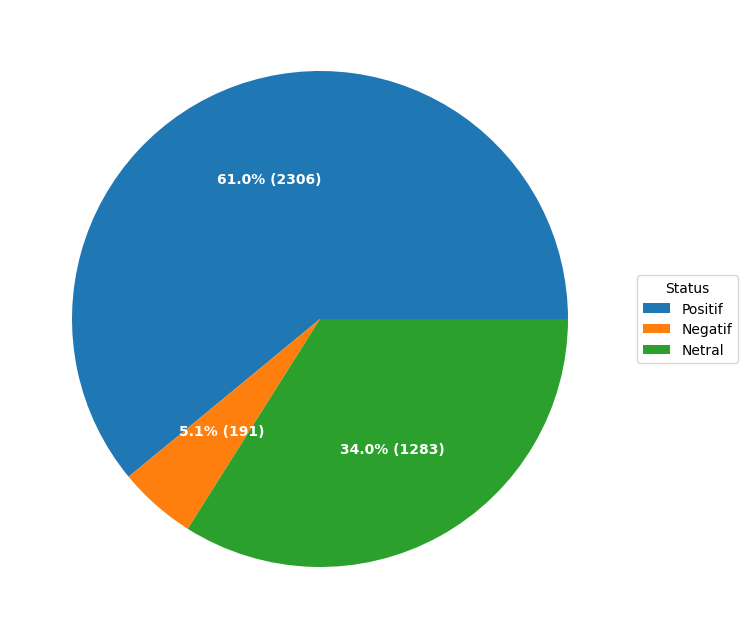

In [36]:
label = ['Positif', 'Negatif', 'Netral']
count_data = [total_positif+1, total_negatif+1, total_netral]

show_pie(label, count_data, "Status")

In [37]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.axis("off");

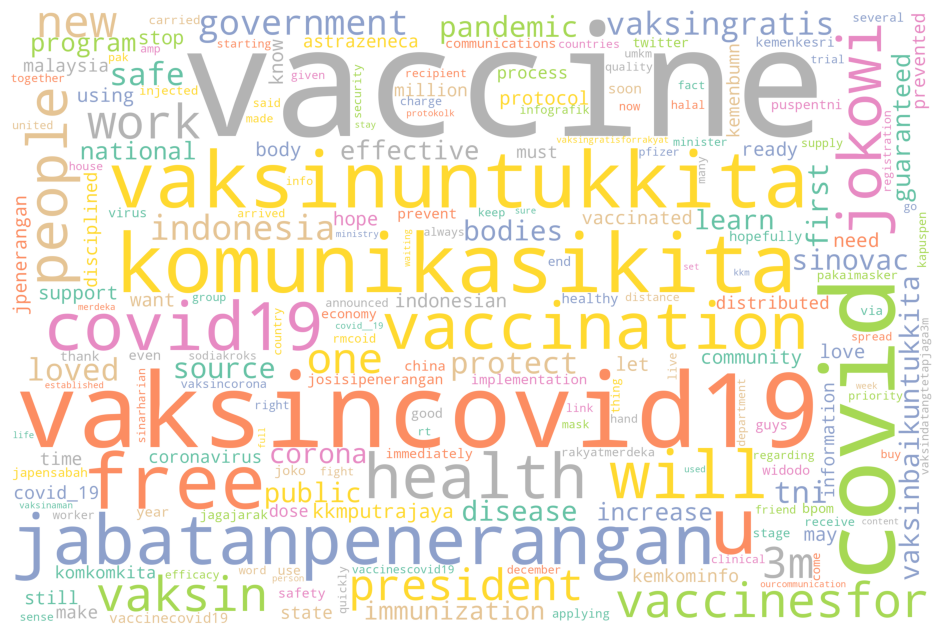

In [38]:
all_words = ' '.join([tweets for tweets in data['tweet_english']])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=3, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(all_words)
plot_cloud(wordcloud)

In [39]:
data_eval = [tuple(x) for x in data.to_records(index=False)]

for n in data_eval:
    if n[5] != n[6]:
       print(f'Text: {n[3]}\nClassifier: {n[5]}\nClassifier Bayes: {n[6]} \n')

Text: Kalau karena merasa tidak takut?Mengapa harus takut Padahal adalah ikhtiar mengahadapi
Classifier: Negatif
Classifier Bayes: Positif 

Text: BPOM Pastikan Keamanan dan Efektivitas Vaksin Surabaya, Indonesia
Classifier: Netral
Classifier Bayes: Positif 

Text: Ramai soal Vaksinasi, Apa Saja sih Sebetulnya Kandungan Vaksin Covid-19 itu?
Classifier: Positif
Classifier Bayes: Netral 

Text: Ramai soal Vaksinasi, Apa Saja sih Sebetulnya Kandungan Vaksin Covid-19 itu?
Classifier: Positif
Classifier Bayes: Netral 

Text: Kalau karena merasa tidak takut?Mengapa harus takut Padahal adalah ikhtiar mengahadapi
Classifier: Negatif
Classifier Bayes: Positif 

Text: Kalau menurut kamu, apakah vaksin merupakan solusi paling tepat untuk wabah covid-19 di Indonesia?.
Classifier: Positif
Classifier Bayes: Netral 

Text: Kalau karena merasa tidak takut?Mengapa harus takut Padahal adalah ikhtiar mengahadapi
Classifier: Negatif
Classifier Bayes: Positif 

Text: Kalau karena merasa tidak takut?Mengapa